In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
import cv2 as cv

# DATASET GENERATOR

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rescale=1./255, validation_split=0.1) 
train = gen.flow_from_directory("/kaggle/input/ASL-SIGN/asl_alphabet_train/asl_alphabet_train", 
                                                            target_size=(64, 64), subset="training")
val = gen.flow_from_directory("/kaggle/input/ASL-SIGN/asl_alphabet_train/asl_alphabet_train", 
                                                            target_size=(64, 64), subset="validation")

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


# VGG-16

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def build_vgg16(input_shape, num_classes):
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Classifier
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Define the input shape and number of classes
input_shape = (64, 64, 3)  # Assumes RGB images
num_classes = 29

# Build the VGG16 model
vgg16_model = build_vgg16(input_shape, num_classes)

# Print the model summary
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                    

In [5]:
# Compile the model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.optimizers import Adam 
opt=Adam(learning_rate=0.0001)
vgg16_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
es=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)
history=vgg16_model.fit(train,validation_data=val,epochs=10, shuffle=True, verbose=1,callbacks = [es])


Epoch 1/10
2447/2447 [==============================] - 637s 255ms/step - loss: 0.8626 - accuracy: 0.7258 - val_loss: 0.6443 - val_accuracy: 0.8203
Epoch 2/10
2447/2447 [==============================] - 124s 51ms/step - loss: 0.0701 - accuracy: 0.9770 - val_loss: 0.5055 - val_accuracy: 0.8480
Epoch 3/10
2447/2447 [==============================] - 123s 50ms/step - loss: 0.0418 - accuracy: 0.9873 - val_loss: 0.5656 - val_accuracy: 0.8223
Epoch 4/10
2447/2447 [==============================] - 127s 52ms/step - loss: 0.0285 - accuracy: 0.9919 - val_loss: 0.2824 - val_accuracy: 0.9198
Epoch 5/10
2447/2447 [==============================] - 126s 51ms/step - loss: 0.0223 - accuracy: 0.9938 - val_loss: 0.4228 - val_accuracy: 0.9032
Epoch 6/10
2447/2447 [==============================] - 122s 50ms/step - loss: 0.0188 - accuracy: 0.9951 - val_loss: 0.3990 - val_accuracy: 0.8917
Epoch 7/10
2447/2447 [==============================] - 122s 50ms/step - loss: 0.0157 - accuracy: 0.9956 - val_loss: 

# VGG16 USING IMAGENET WEIGHTS

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

def build_vgg16(input_shape, num_classes):
    # Load the VGG16 model without the top classification layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    # Add a new classification layer
    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

# Define the input shape and number of classes
input_shape = (64, 64, 3)  # Assumes RGB images
num_classes = 29

# Build the VGG16 model with ImageNet weights
pvgg16_model = build_vgg16(input_shape, num_classes)

# Print the model summary
pvgg16_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [7]:
# Compile the model
opt=Adam(learning_rate=0.0001)
pvgg16_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
es=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)
history=pvgg16_model.fit(train,validation_data=val,epochs=10, shuffle=True, verbose=1,callbacks = [es])

Epoch 1/10
2447/2447 [==============================] - 131s 51ms/step - loss: 0.1836 - accuracy: 0.9433 - val_loss: 0.1846 - val_accuracy: 0.9497
Epoch 2/10
2447/2447 [==============================] - 121s 50ms/step - loss: 0.0346 - accuracy: 0.9916 - val_loss: 0.1048 - val_accuracy: 0.9725
Epoch 3/10
2447/2447 [==============================] - 123s 50ms/step - loss: 0.0252 - accuracy: 0.9944 - val_loss: 0.2147 - val_accuracy: 0.9615
Epoch 4/10
2447/2447 [==============================] - 124s 51ms/step - loss: 0.0255 - accuracy: 0.9947 - val_loss: 0.0463 - val_accuracy: 0.9868
Epoch 5/10
2447/2447 [==============================] - 124s 51ms/step - loss: 0.0191 - accuracy: 0.9964 - val_loss: 0.0745 - val_accuracy: 0.9839
Epoch 6/10
2447/2447 [==============================] - 124s 51ms/step - loss: 0.0083 - accuracy: 0.9985 - val_loss: 0.4548 - val_accuracy: 0.9020
Epoch 7/10
2447/2447 [==============================] - 124s 51ms/step - loss: 0.0144 - accuracy: 0.9973 - val_loss: 0

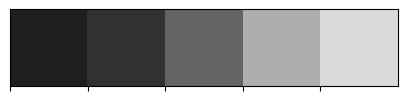

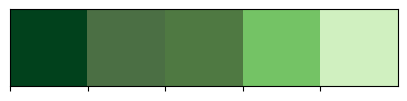

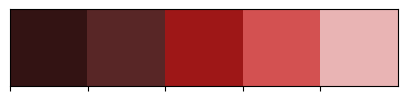

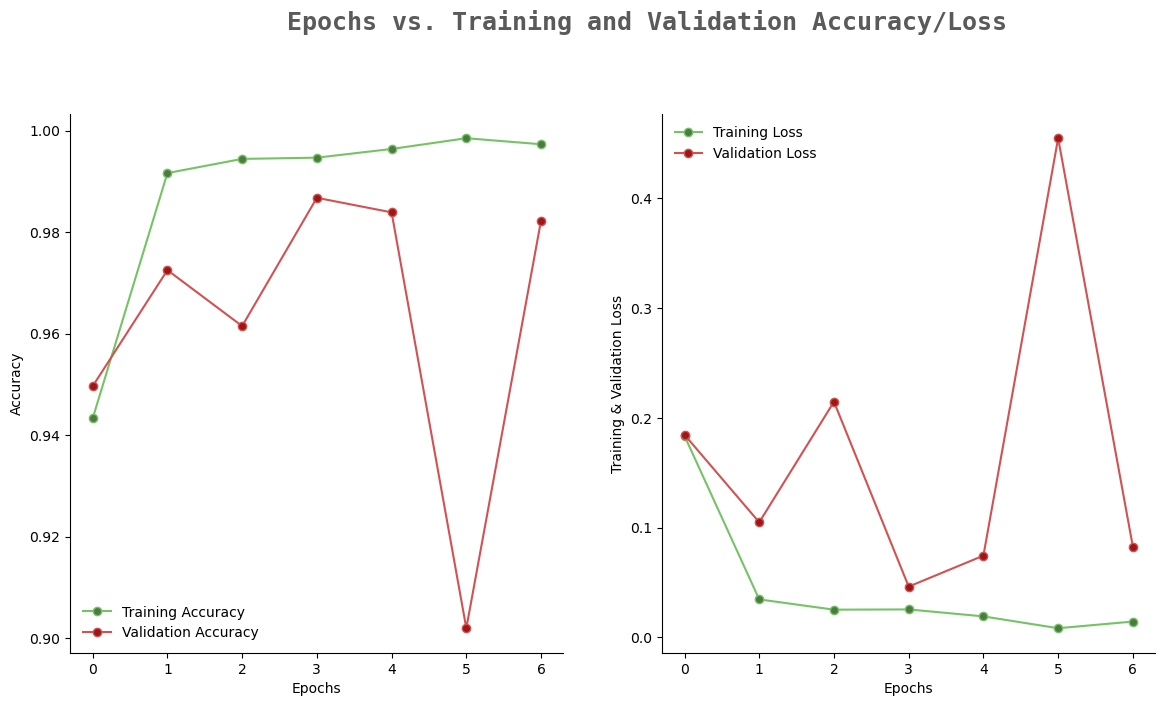

In [9]:
import seaborn as sns
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)
# filterwarnings('ignore')

epochs = [i for i in range(7)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [10]:
pvgg16_model.save('VGG16_FINAL_MODEL1.h5')

# vgg-16 DENSE Layer changed

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

def build_vgg16(input_shape, num_classes):
    # Load the VGG16 model without the top classification layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    # Add a new classification layer
    x = base_model.output
    x = Flatten()(x)
    x=Dense(256,activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

# Define the input shape and number of classes
input_shape = (64, 64, 3)  # Assumes RGB images
num_classes = 29

# Build the VGG16 model with ImageNet weights
dvgg16_model = build_vgg16(input_shape, num_classes)

# Print the model summary
dvgg16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [12]:
# Compile the model
opt=Adam(learning_rate=0.0001)
dvgg16_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
es=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)
history=dvgg16_model.fit(train,validation_data=val,epochs=10, shuffle=True, verbose=1,callbacks = [es])

Epoch 1/10
2447/2447 [==============================] - 128s 50ms/step - loss: 0.1359 - accuracy: 0.9592 - val_loss: 0.1502 - val_accuracy: 0.9610
Epoch 2/10
2447/2447 [==============================] - 126s 51ms/step - loss: 0.0251 - accuracy: 0.9936 - val_loss: 0.2589 - val_accuracy: 0.9152
Epoch 3/10
2447/2447 [==============================] - 122s 50ms/step - loss: 0.0150 - accuracy: 0.9963 - val_loss: 0.0551 - val_accuracy: 0.9837
Epoch 4/10
2447/2447 [==============================] - 121s 50ms/step - loss: 0.0082 - accuracy: 0.9982 - val_loss: 0.0477 - val_accuracy: 0.9853
Epoch 5/10
2447/2447 [==============================] - 124s 50ms/step - loss: 0.0190 - accuracy: 0.9956 - val_loss: 0.0740 - val_accuracy: 0.9787
Epoch 6/10
2447/2447 [==============================] - 138s 56ms/step - loss: 0.0141 - accuracy: 0.9972 - val_loss: 0.0897 - val_accuracy: 0.9834
Epoch 7/10
2447/2447 [==============================] - 123s 50ms/step - loss: 0.0085 - accuracy: 0.9986 - val_loss: 0

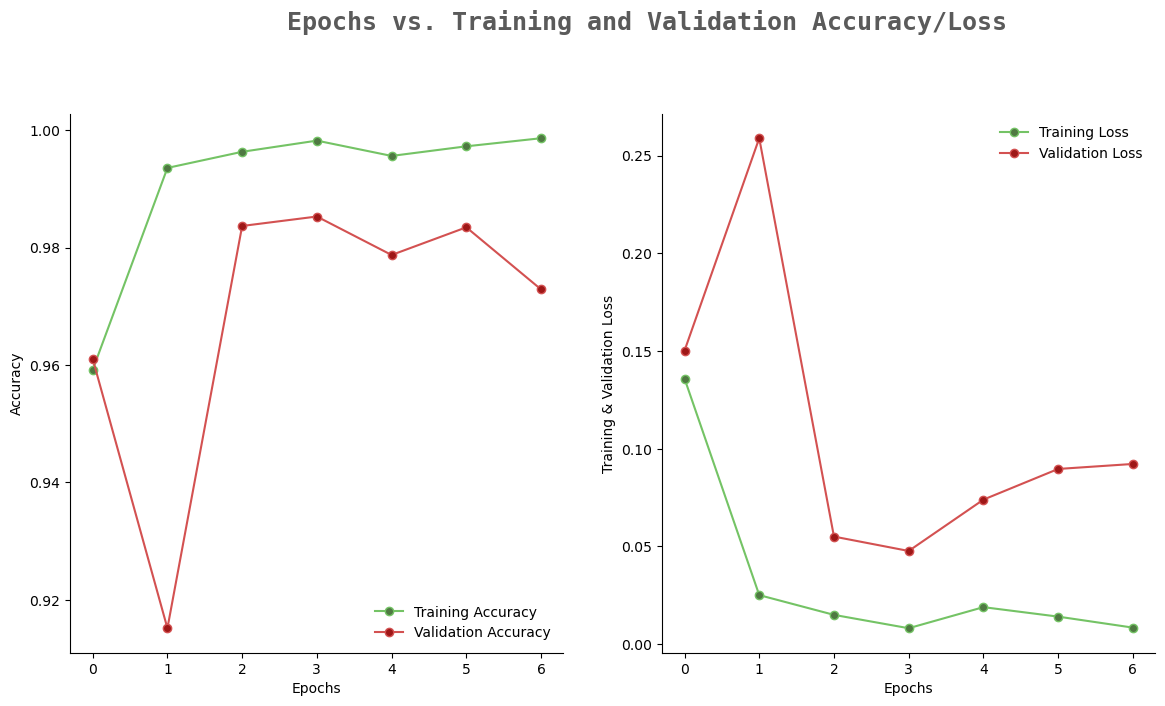

In [13]:
import seaborn as sns
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

epochs = [i for i in range(7)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

# SAVE MODEL

In [14]:
test = ImageDataGenerator(rescale=1./255).flow_from_directory("/kaggle/input/ASL-SIGN/asl_alphabet_test", 
                                                                  target_size=(64, 64), class_mode=None,)
pred = dvgg16_model.predict(test)
pred = np.argmax(pred, axis=1)
pred

Found 27 images belonging to 1 classes.
1/1 [==============================] - 1s 535ms/step


array([14, 28, 20,  3, 25,  5, 17,  4,  8, 13, 12, 21, 23,  2, 27,  6, 19,
       16, 22,  1, 15,  9, 11, 18,  7, 10, 24])

In [15]:
dvgg16_model.save('VGG16_FINAL_MODEL2.h5')

In [16]:
os.listdir("/kaggle/working/")

['.virtual_documents',
 'VGG16_FINAL_MODEL2.h5',
 'VGG16_FINAL_MODEL1.h5',
 '__notebook_source__.ipynb']

In [18]:
for i in range(1,26):
#     print(chr(65+i))
    img=cv.imread("/kaggle/input/ASL-SIGN/asl_alphabet_test/asl_alphabet_test/{}_test.jpg".format(chr(65+i)),3)
    img=cv.resize(img,(64,64))
    img=img/255.0
    img = img.reshape(1,64, 64,3)


    # img = img.reshape(1,224, 224,3)    
    # print(img)

    result = dvgg16_model.predict(img, batch_size=1)
    # print(result)
    # result=[round(i) for i in result[0]]
    print(list(result[0]).index(max(list(result[0]))))
    # one_position=result.index(1)
    # print(one_position)
    # if one_position<26:
    #     print(chr(one_position+65))
    # else:
    #     d={
    #         26:"del",
    #         27:"nothing",
    #         28:"space"
    #     }
    #     print(d[one_position])

1/1 [==============================] - 0s 181ms/step
1
1/1 [==============================] - 0s 17ms/step
2
1/1 [==============================] - 0s 16ms/step
3
1/1 [==============================] - 0s 17ms/step
4
1/1 [==============================] - 0s 17ms/step
5
1/1 [==============================] - 0s 17ms/step
6
1/1 [==============================] - 0s 18ms/step
7
1/1 [==============================] - 0s 17ms/step
8
1/1 [==============================] - 0s 17ms/step
9
1/1 [==============================] - 0s 18ms/step
10
1/1 [==============================] - 0s 16ms/step
11
1/1 [==============================] - 0s 17ms/step
12
1/1 [==============================] - 0s 16ms/step
13
1/1 [==============================] - 0s 16ms/step
14
1/1 [==============================] - 0s 16ms/step
15
1/1 [==============================] - 0s 17ms/step
16
1/1 [==============================] - 0s 16ms/step
17
1/1 [==============================] - 0s 16ms/step
18
1/1 [=============

# RESNET-50

In [19]:
input_shape = 64, 64, 3
n_classes = 29
from tensorflow import keras
# Load pre-trained ImageNet weights
weights_path = keras.applications.resnet50.weights='imagenet'
# Define the ResNet-50 model without top layers
base_model = keras.applications.ResNet50(
    include_top=False,
    weights=weights_path,
    input_shape=(64, 64, 3),
)
# Add custom top layers
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
predictions = keras.layers.Dense(29, activation='softmax')(x)

# Create the final model
model = keras.models.Model(inputs=base_model.input, outputs=predictions)



# Compile the model

opt=Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
es=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)
history=model.fit(train,validation_data=val,epochs=10, shuffle=True, verbose=1,callbacks = [es])

94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/10
2447/2447 [==============================] - 200s 66ms/step - loss: 0.1878 - accuracy: 0.9492 - val_loss: 0.3133 - val_accuracy: 0.9101
Epoch 2/10
2447/2447 [==============================] - 159s 65ms/step - loss: 0.0261 - accuracy: 0.9931 - val_loss: 0.1765 - val_accuracy: 0.9498
Epoch 3/10
2447/2447 [==============================] - 160s 65ms/step - loss: 0.0217 - accuracy: 0.9949 - val_loss: 0.2940 - val_accuracy: 0.9283
Epoch 4/10
2447/2447 [==============================] - 158s 65ms/step - loss: 0.0148 - accuracy: 0.9963 - val_loss: 0.1511 - val_accuracy: 0.9637
Epoch 5/10
2447/2447 [==============================] - 157s 64ms/step - loss: 0.0114 - accuracy: 0.9974 - val_loss: 0.3213 - val_accuracy: 0.9375
Epoch 6/10
2447/2447 [==============================] - 169s 69ms/step - loss: 0.0125 - accuracy: 0.9972 - val_loss: 0.1185 - val_accuracy: 0.9663
Epoch 7/10
2447/2447 [==============================]

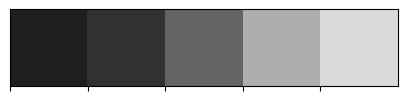

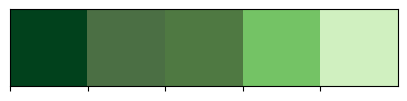

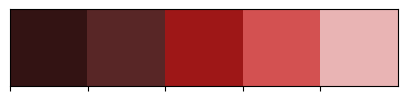

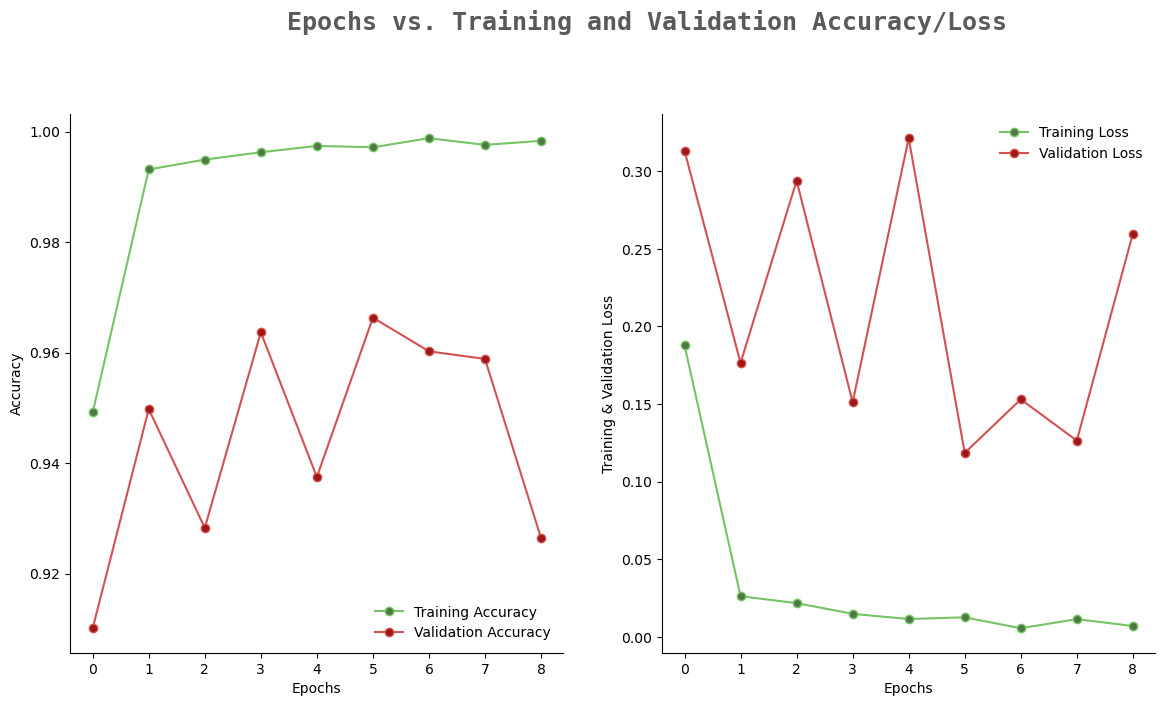

In [20]:
import seaborn as sns
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)
# filterwarnings('ignore')

epochs = [i for i in range(9)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [21]:
test = ImageDataGenerator(rescale=1./255).flow_from_directory("/kaggle/input/ASL-SIGN/asl_alphabet_test", 
                                                            target_size=(64, 64), class_mode=None,)
pred = model.predict(test)
pred = np.argmax(pred, axis=1)
pred

Found 27 images belonging to 1 classes.
1/1 [==============================] - 2s 2s/step


array([28, 25, 20,  1,  9, 18,  8, 10, 19, 24,  3, 27, 15, 16,  4,  7, 17,
       14,  2, 23,  6, 11, 21,  5, 12, 22, 13])

In [22]:
model.save('RESNET50_MODEL.h5')

In [23]:
os.listdir("/kaggle/working/")

['.virtual_documents',
 'RESNET50_MODEL.h5',
 'VGG16_FINAL_MODEL2.h5',
 'VGG16_FINAL_MODEL1.h5',
 '__notebook_source__.ipynb']

# DENSENET 121

In [26]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import decode_predictions
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.layers import Input,ZeroPadding2D,Activation,Add
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam 
import tensorflow as tf
from PIL import Image 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
import numpy as np 
import os 
from tensorflow.keras.initializers import glorot_uniform

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
# Creating Densenet121
def densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model
input_shape = 64, 64,3
n_classes = 29
Dmodel = densenet(input_shape,n_classes)
# model.summary()

In [32]:
opt=Adam(learning_rate=0.0001)
Dmodel.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
es=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)
history=Dmodel.fit(train,validation_data=val,epochs=10, shuffle=True, verbose=1,callbacks = [es])

Epoch 1/10
2447/2447 [==============================] - 378s 109ms/step - loss: 0.4804 - accuracy: 0.8644 - val_loss: 1.3091 - val_accuracy: 0.6161
Epoch 2/10
2447/2447 [==============================] - 264s 108ms/step - loss: 0.0641 - accuracy: 0.9801 - val_loss: 0.9692 - val_accuracy: 0.7951
Epoch 3/10
 791/2447 [========>.....................] - ETA: 2:47 - loss: 0.0445 - accuracy: 0.9872

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2447/2447 [==============================] - 260s 106ms/step - loss: 0.0430 - accuracy: 0.9874 - val_loss: 5.3348 - val_accuracy: 0.3793
Epoch 4/10
2447/2447 [==============================] - 261s 107ms/step - loss: 0.0278 - accuracy: 0.9922 - val_loss: 0.5324 - val_accuracy: 0.8567
Epoch 5/10
 530/2447 [=====>........................] - ETA: 3:14 - loss: 0.0301 - accuracy: 0.9911

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2447/2447 [==============================] - 260s 106ms/step - loss: 0.0233 - accuracy: 0.9933 - val_loss: 0.5816 - val_accuracy: 0.8625
Epoch 6/10
2447/2447 [==============================] - 265s 108ms/step - loss: 0.0196 - accuracy: 0.9946 - val_loss: 1.1203 - val_accuracy: 0.7654
Epoch 7/10
2447/2447 [==============================] - 262s 107ms/step - loss: 0.0131 - accuracy: 0.9964 - val_loss: 0.2408 - val_accuracy: 0.9446
Epoch 8/10
2447/2447 [==============================] - 258s 106ms/step - loss: 0.0164 - accuracy: 0.9958 - val_loss: 0.4127 - val_accuracy: 0.8889
Epoch 9/10
2447/2447 [==============================] - 259s 106ms/step - loss: 0.0090 - accuracy: 0.9976 - val_loss: 0.6748 - val_accuracy: 0.8829
Epoch 10/10
2447/2447 [==============================] - 260s 106ms/step - loss: 0.0122 - accuracy: 0.9966 - val_loss: 0.7797 - val_accuracy: 0.8247
Epoch 10: early stopping


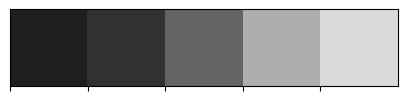

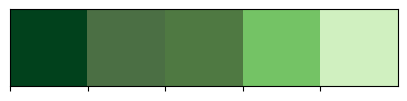

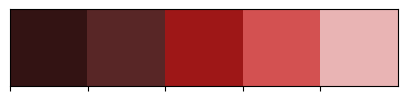

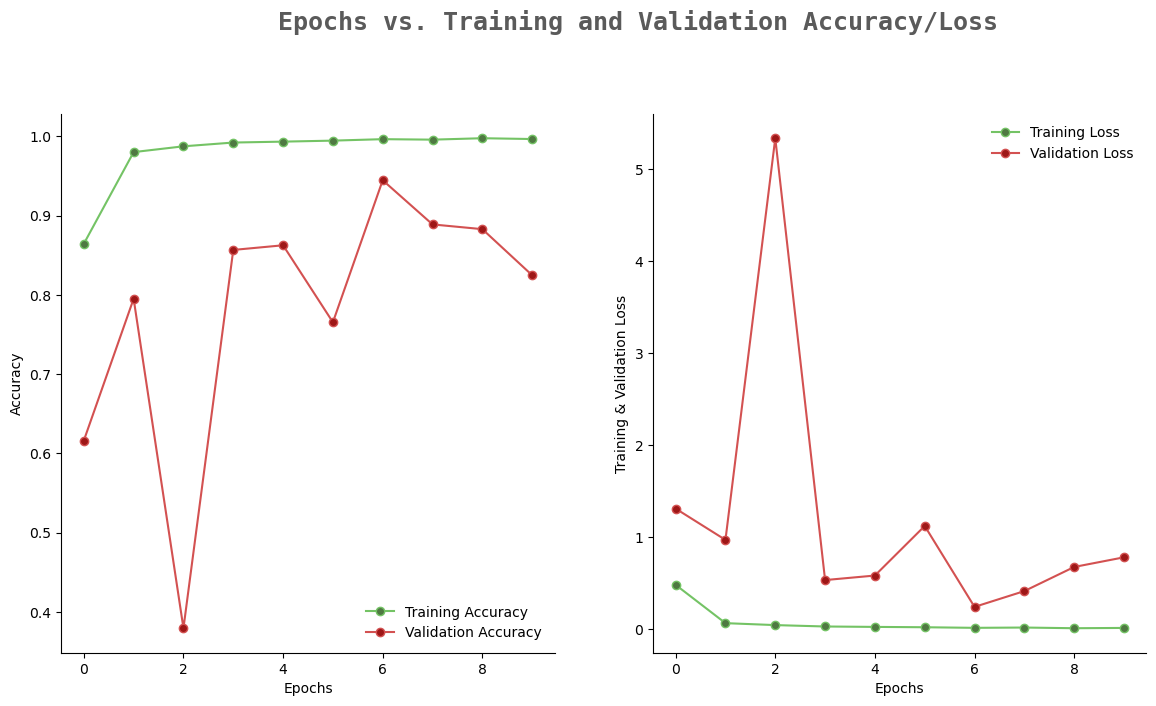

In [33]:
import seaborn as sns
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)
# filterwarnings('ignore')

epochs = [i for i in range(10)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [34]:
Dmodel.save('DENSNET121.h5')

In [35]:
os.listdir("/kaggle/working/")

['.virtual_documents',
 'RESNET50_MODEL.h5',
 'VGG16_FINAL_MODEL2.h5',
 'DENSNET121.h5',
 'VGG16_FINAL_MODEL1.h5',
 '__notebook_source__.ipynb']